<a href="https://colab.research.google.com/github/adonapati/GenAI-Remote-Sensing/blob/main/Flood_detection_using_Sentinel_satellite_pictures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from numba import cuda

cuda.select_device(0)
cuda.close()

tf.keras.backend.clear_session()

In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
franciscoescobar_satellite_images_of_water_bodies_path = kagglehub.dataset_download('franciscoescobar/satellite-images-of-water-bodies')
sovitrath_water_bodies_segmentation_dataset_with_split_path = kagglehub.dataset_download('sovitrath/water-bodies-segmentation-dataset-with-split')
hhrclemson_flooding_image_dataset_path = kagglehub.dataset_download('hhrclemson/flooding-image-dataset')

print('Data source import complete.')


100%|██████████| 247M/247M [00:05<00:00, 43.8MB/s]


Extracting files...


100%|██████████| 247M/247M [00:03<00:00, 81.9MB/s]

Extracting files...


100%|██████████| 11.1G/11.1G [02:52<00:00, 69.2MB/s]

Extracting files...


Data source import complete.


In [2]:
import cv2
import numpy as np
import tensorflow as tf
import keras
import glob
import albumentations as A
import matplotlib.pyplot as plt
import time

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


# DATASET FORMATION

In [3]:
import os
os.listdir('/root/.cache/kagglehub/datasets/sovitrath/water-bodies-segmentation-dataset-with-split/versions/1/Water_Bodies_Dataset_Split')
os.listdir('/root/.cache/kagglehub/datasets/franciscoescobar/satellite-images-of-water-bodies/versions/2/Water Bodies Dataset/Images')

['water_body_7819.jpg',
 'water_body_1115.jpg',
 'water_body_791.jpg',
 'water_body_1311.jpg',
 'water_body_8489.jpg',
 'water_body_7288.jpg',
 'water_body_7100.jpg',
 'water_body_8484.jpg',
 'water_body_8011.jpg',
 'water_body_8834.jpg',
 'water_body_8745.jpg',
 'water_body_7566.jpg',
 'water_body_719.jpg',
 'water_body_8694.jpg',
 'water_body_650.jpg',
 'water_body_730.jpg',
 'water_body_100.jpg',
 'water_body_7871.jpg',
 'water_body_7150.jpg',
 'water_body_2189.jpg',
 'water_body_8736.jpg',
 'water_body_7489.jpg',
 'water_body_27.jpg',
 'water_body_2237.jpg',
 'water_body_2169.jpg',
 'water_body_1235.jpg',
 'water_body_2432.jpg',
 'water_body_7207.jpg',
 'water_body_7816.jpg',
 'water_body_2439.jpg',
 'water_body_2530.jpg',
 'water_body_2337.jpg',
 'water_body_1157.jpg',
 'water_body_7317.jpg',
 'water_body_8294.jpg',
 'water_body_8849.jpg',
 'water_body_24.jpg',
 'water_body_7588.jpg',
 'water_body_1726.jpg',
 'water_body_2370.jpg',
 'water_body_7380.jpg',
 'water_body_54.jpg',
 'w

In [4]:
tf.config.run_functions_eagerly(True)

In [5]:
image_filename = '/root/.cache/kagglehub/datasets/sovitrath/water-bodies-segmentation-dataset-with-split/versions/1/Water_Bodies_Dataset_Split/train_images/*.jpg'
masks_filename = '/root/.cache/kagglehub/datasets/sovitrath/water-bodies-segmentation-dataset-with-split/versions/1/Water_Bodies_Dataset_Split/train_masks/*.jpg'

In [6]:
img_filename_list = []
for files in sorted(glob.glob(image_filename)):
    img_filename_list.append(files)

mask_filename_list = []
for files in sorted(glob.glob(masks_filename)):
    mask_filename_list.append(files)


In [7]:
print(len(img_filename_list))
print(len(mask_filename_list))

2683
2683


In [8]:
train_img_filename_list = img_filename_list[:1000]
train_mask_filename_list = mask_filename_list[:1000]

In [9]:
test_img_filename_list = img_filename_list[1500:2000]
test_mask_filename_list = mask_filename_list[1500:2000]

In [10]:
dataset = tf.data.Dataset.from_tensor_slices((train_img_filename_list, train_mask_filename_list))

In [11]:
def decode_images(img_filename, mask_filename):
    image_string = tf.io.read_file(img_filename)
    mask_string = tf.io.read_file(mask_filename)

    #Don't use tf.image.decode_image, or the output shape will be undefined
    image = tf.image.decode_jpeg(image_string, channels=3)
    mask = tf.image.decode_jpeg(mask_string, channels=1)

    #This will convert to float values in [0, 1]
    image = tf.image.convert_image_dtype(image, tf.float32)
    mask = tf.image.convert_image_dtype(mask, tf.float32)

    image = tf.image.resize(image, (128, 128))
    mask = tf.image.resize(mask, (128, 128))

    return image, mask

In [12]:
dataset = dataset.map(decode_images)
dataset = dataset.batch(16)
dataset = dataset.prefetch(1)

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


In [13]:
dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None))>

In [14]:
im, m = next(iter(dataset))

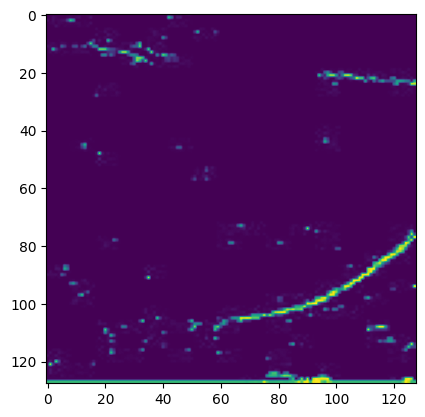

In [15]:
plt.imshow(m[5])

# UNET MODEL

In [16]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda

# U-Net model using functions
def conv_block(input, num_filters):
  x = Conv2D(num_filters, 3, padding = 'same', activation = 'relu')(input)
  x = BatchNormalization()(x)

  x = Conv2D(num_filters, 3, padding = 'same', activation = 'relu')(x)
  x = BatchNormalization()(x)
  return x

def encoder_block(input, num_filters):
  x = conv_block(input, num_filters)
  p = MaxPooling2D((2, 2))(x)
  return x, p

def decoder_block(input, skip_features, num_filters):
  x = Conv2DTranspose(num_filters, (2, 2), strides = 2, padding = 'same')(input)
  x = concatenate([x, skip_features])
  x = conv_block(x, num_filters)
  return x

In [20]:
inputs = Input((128, 128, 3))
s1, p1 = encoder_block(inputs, 64)
s2, p2 = encoder_block(p1, 128)
s3, p3 = encoder_block(p2, 256)
s4, p4 = encoder_block(p3, 512)

b1 = conv_block(p4, 1024)

d1 = decoder_block(b1, s4, 512)
d2 = decoder_block(d1, s3, 256)
d3 = decoder_block(d2, s2, 128)
d4 = decoder_block(d3, s1, 64)

outputs = Conv2D(1, 1, padding = 'same', activation = 'sigmoid')(d4)
model = Model(inputs=[inputs], outputs=[outputs])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_19 (Conv2D)        │ (None, 128, 128, 64)   │          1,792 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_18    │ (None, 128, 128, 64)   │            256 │ conv2d_19[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_20 (Conv2D)        │ (None, 128, 128, 64)   │         36,928 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_19    │ (None, 128, 128, 64)   │            256 │ conv2d_20[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 64, 64, 64)     │              0 │ batch_normalization_1… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_21 (Conv2D)        │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_20    │ (None, 64, 64, 128)    │            512 │ conv2d_21[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_22 (Conv2D)        │ (None, 64, 64, 128)    │        147,584 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_21    │ (None, 64, 64, 128)    │            512 │ conv2d_22[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_5           │ (None, 32, 32, 128)    │              0 │ batch_normalization_2… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_23 (Conv2D)        │ (None, 32, 32, 256)    │        295,168 │ max_pooling2d_5[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_22    │ (None, 32, 32, 256)    │          1,024 │ conv2d_23[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_24 (Conv2D)        │ (None, 32, 32, 256)    │        590,080 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_23    │ (None, 32, 32, 256)    │          1,024 │ conv2d_24[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 31,055,297 (118.47 MB)

 Trainable params: 31,043,521 (118.42 MB)

 Non-trainable params: 11,776 (46.00 KB)

# COMPILING AND TRAINING THE MODEL

In [22]:
model.compile(optimizer = 'adam', loss = keras.losses.BinaryCrossentropy(), metrics = ['accuracy'])

In [23]:
with tf.device("/device:GPU:0"):
    starting_time= time.time()
    history = model.fit(dataset, batch_size = 32, epochs = 47, verbose = 1)
    print('Total time', time.time() - starting_time)


Epoch 1/47
63/63 ━━━━━━━━━━━━━━━━━━━━ 67s 873ms/step - accuracy: 0.5867 - loss: 0.6210
Epoch 2/47
63/63 ━━━━━━━━━━━━━━━━━━━━ 65s 782ms/step - accuracy: 0.6278 - loss: 0.5001
Epoch 3/47
63/63 ━━━━━━━━━━━━━━━━━━━━ 50s 782ms/step - accuracy: 0.6362 - loss: 0.4853
Epoch 4/47
63/63 ━━━━━━━━━━━━━━━━━━━━ 82s 798ms/step - accuracy: 0.6436 - loss: 0.4746
Epoch 5/47
63/63 ━━━━━━━━━━━━━━━━━━━━ 81s 790ms/step - accuracy: 0.6473 - loss: 0.4556
Epoch 6/47
63/63 ━━━━━━━━━━━━━━━━━━━━ 82s 792ms/step - accuracy: 0.6515 - loss: 0.4545
Epoch 7/47
63/63 ━━━━━━━━━━━━━━━━━━━━ 82s 792ms/step - accuracy: 0.6569 - loss: 0.4430
Epoch 8/47
63/63 ━━━━━━━━━━━━━━━━━━━━ 50s 794ms/step - accuracy: 0.6652 - loss: 0.4342
Epoch 9/47
63/63 ━━━━━━━━━━━━━━━━━━━━ 82s 797ms/step - accuracy: 0.6656 - loss: 0.4221
Epoch 10/47
63/63 ━━━━━━━━━━━━━━━━━━━━ 82s 804ms/step - accuracy: 0.6708 - loss: 0.4189
Epoch 11/47
63/63 ━━━━━━━━━━━━━━━━━━━━ 81s 790ms/step - accuracy: 0.6820 - loss: 0.3975
Epoch 12/47
63/63 ━━━━━━━━━━━━━━━━━━━━ 93

# PREDICTION USING TEST DATASET

In [24]:
test_img_file = '/root/.cache/kagglehub/datasets/franciscoescobar/satellite-images-of-water-bodies/versions/2/Water Bodies Dataset/Images/*.jpg'
test_img_files = []
for files in sorted(glob.glob(test_img_file)):
    test_img_files.append(files)
print(len(test_img_files))

2841


In [25]:
test_mask_file = '/root/.cache/kagglehub/datasets/franciscoescobar/satellite-images-of-water-bodies/versions/2/Water Bodies Dataset/Masks/*.jpg'
test_mask_files = []
for files in sorted(glob.glob(test_mask_file)):
    test_mask_files.append(files)
print(len(test_mask_files))

2841


In [26]:
test_dataset = tf.data.Dataset.from_tensor_slices(test_img_files)

In [27]:
def decode_test_images(img_filename):
    image_string = tf.io.read_file(img_filename)


    #Don't use tf.image.decode_image, or the output shape will be undefined
    image = tf.image.decode_jpeg(image_string, channels=3)


    #This will convert to float values in [0, 1]
    image = tf.image.convert_image_dtype(image, tf.float32)


    image = tf.image.resize(image, [128, 128])


    return image

In [28]:
test_dataset = test_dataset.map(decode_test_images)
#test_dataset = test_dataset.batch(16)

In [29]:
test_dataset = test_dataset.batch(16)

In [30]:
im = next(iter(test_dataset))

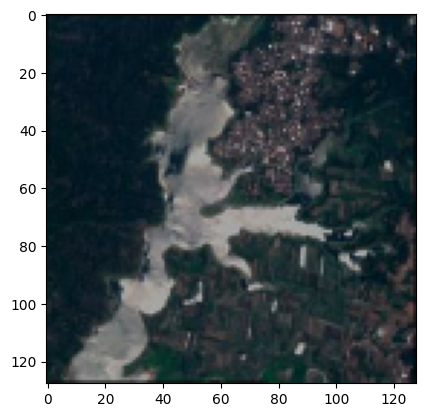

In [31]:
plt.imshow(im[1])

In [32]:
test_dataset

<_BatchDataset element_spec=TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None)>

In [33]:
 output = model.predict(test_dataset, batch_size = 16)

178/178 ━━━━━━━━━━━━━━━━━━━━ 27s 154ms/step


In [34]:
output.shape

(2841, 128, 128, 1)

In [35]:
predictions = []
for i in  range(2683):
    pred = np.array(output[i])
    pred = (pred)
    predictions.append(pred)

In [36]:
y_test = []
for i in range(len(test_mask_files)):
    mask = tf.image.decode_jpeg(tf.io.read_file(test_mask_files[i]), channels = 1)
    mask = tf.image.resize(mask,[128, 128])
    y_test.append(mask)

In [43]:
# IoU measurement
iou_scores = []
for i in range(500):
    intersection = np.logical_and(y_test[i], predictions[i])
    union = np.logical_or(y_test[i], predictions[i])
    iou_score = np.sum(intersection) / np.sum(union)
    iou_scores.append(iou_score)

# Use the correct number of samples for averaging
average_iou = sum(iou_scores) / len(iou_scores)
print("IoU score is:", average_iou)


IoU score is: 0.4670506591796875


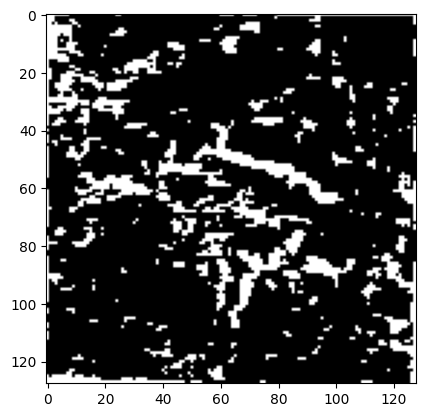

In [41]:
plt.imshow((output[0] > 0.1), cmap = 'gray')

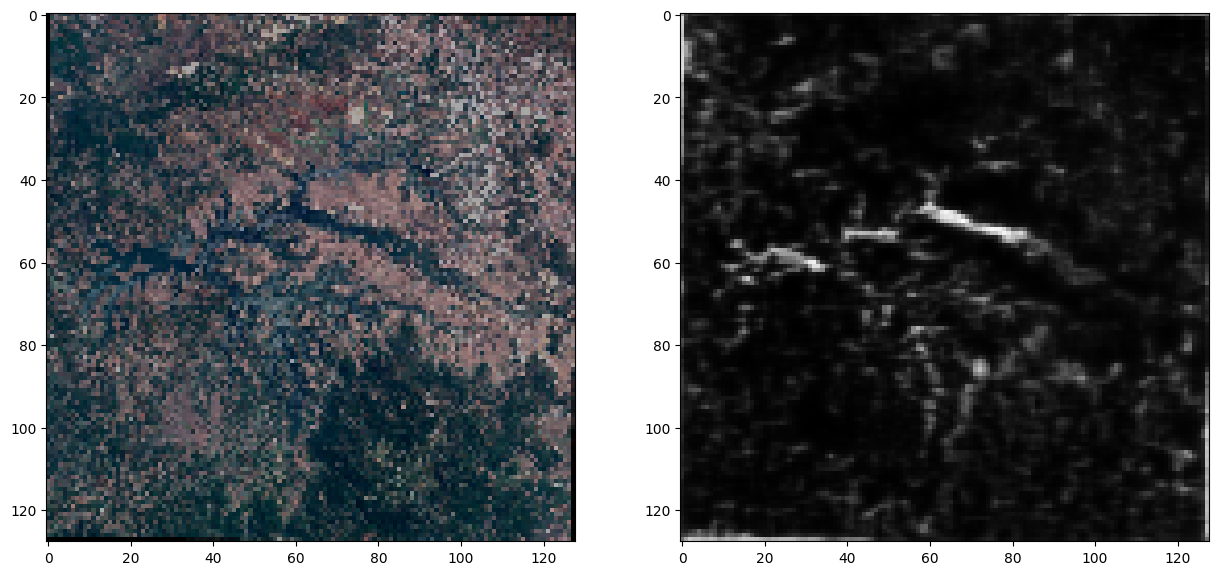

In [42]:
fig = plt.figure(figsize =(15, 15))
ax1 = fig.add_subplot(121)
ax1 = plt.imshow(im[0])
ax2 = fig.add_subplot(122)
ax2 = plt.imshow(predictions[0], cmap = 'gray')